| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This Jupyter Notebook is licensed under GPL 3.0. Please visit our Github organization for more information:  https://github.com/edgi-govdata-archiving/
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

# Who's responsible for greenhouse gas emissions?
Under the US Environmental Protection Agency's Greenhouse Gas Reporting Program (GHGRP), a variety of emitters are required to count and report their emissions anually. 

Conceptually this is similar to reporting pollutant discharages under the Clean Water Act's National Pollutant Discharge Elimination System (NPDES), but whereas NPDES has legal teeth - facilities are permitted to release only so much of a pollutant into the water - there is no such equivalent legislation for greenhouse gases (GHGs).

Facilities reporting GHGs are also required to report information about ownership - the share a parent company has in the facility. Through this information we can determine not just which specific facilities reported the most GHGs every year, but which companies can be said to be the most responsible in terms of their ownership of these facilities.

The GHGRP does not attempt to account for all of the US's GHG emissions; the [GHG Inventory](https://www.epa.gov/ghgemissions/inventory-us-greenhouse-gas-emissions-and-sinks) does that. But GHGRP focuses on industrial direct emitters and some suppliers above certain thresholds. As EPA notes, "The GHGRP does not represent total U.S. GHG emissions, but provides facility level data for large sources of direct emissions, thus representing the majority of U.S. GHG emissions. The GHGRP data collected from direct emitters represent about half of all U.S. emissions." Including estimates from suppliers of fossil fuels, the GHGRP dataset [can account for](https://www.epa.gov/ghgreporting/learn-about-greenhouse-gas-reporting-program-ghgrp) up to 90% of all US emissions. 

As EPA [notes](https://ccdsupport.com/confluence/pages/viewpage.action?pageId=98598976), "Data from direct emitters and suppliers cannot be viewed together because it would cause double counting of emissions in many sectors.  In general, it is more accurate to look at upstream (also called suppliers) data separately from downstream (also called direct emitters) data." EPA [elaborates](https://ccdsupport.com/confluence/pages/viewpage.action?pageId=98598975) on the differences between direct emitters and suppliers:

> "Direct emitters" are facilities that combust fuels or otherwise put GHGs into the atmosphere directly from their facility.  An example of this is a power plant that burns coal or natural gas and emits carbon dioxide directly into the atmosphere...."Suppliers" are those entities that supply products into the economy which if combusted, released or oxidized emit greenhouse gases into the atmosphere.  These fuels and industrial gases are not emitted from the supplier facility but instead distributed throughout the country and used.  An example of this is gasoline, which is sold in the U.S. and primarily burned in cars throughout the country."

This notebook uses self-reported data from both emitters and suppliers to estimate GHG emissions by parent company. For further information about how the EPA's GHGRP works, please see our PowerPoint slides [here](https://docs.google.com/presentation/d/1EVtWOFDEeaqZhg1FTf0IsEL3M736hITP5G76q9l6bP0/edit?usp=sharing) or the EPA's website [here](https://www.epa.gov/ghgreporting). For a full FAQ, see EPA's [helpdesk](https://ccdsupport.com/confluence/display/faq/GHG+Data+and+Publication).

# Setup
Here we load some helper code to get us going. Run the following cell of code. When it says "Done!" proceed to the next step.

In [1]:
# Import code libraries
import pandas as pd
import requests, zipfile, io
!pip install pyxlsb &>/dev/null;
import pyxlsb
!pip install geopandas &>/dev/null;
from IPython.core.display import HTML
import ipywidgets as widgets

!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git &>/dev/null;

import warnings
warnings.filterwarnings('ignore')

print("Done!")

Done!


# Getting emissions data

Pick which year you want to focus on. Run the cell of code, choose a year from the dropdown menu, and then proceed to the next step.

In [2]:
years = ["2016", "2017", "2018", "2019", "2020"]

years_dropdown = widgets.Dropdown(
  options = years,
  value = '2020',
  description='Year:',
  disabled=False
)

display(years_dropdown)

Dropdown(description='Year:', index=4, options=('2016', '2017', '2018', '2019', '2020'), value='2020')

We will "download" EPA's emissions data for that year into this notebook.

In [3]:
# First we request EPA's datafile and unzip it.
url = "https://www.epa.gov/system/files/other-files/2021-10/2020_data_summary_spreadsheets.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content")

# We will load in the sheets in the unzipped XLSX file that contain various kinds of direct emissions, from individual facilities and sectors/activities
year = years_dropdown.value
ghg_fac = pd.read_excel("/content/ghgp_data_"+year+".xlsx",
  skiprows = 1, # skip the first two rows, which are irrelevant
  header = 2, # the third row represents the header
  converters={'Primary NAICS Code':str}, # read the NAICS codes as strings
  sheet_name = ["Direct Emitters", "Onshore Oil & Gas Prod.", "Gathering & Boosting", 
    "Transmission Pipelines", "LDC - Direct Emissions", "SF6 from Elec. Equip.", "Suppliers"]) 

# We will also load in a file that tells us about the type of industry each facility is classified as
naics = pd.read_excel("https://www.census.gov/naics/2017NAICS/6-digit_2017_Codes.xlsx",
  header = 0, # the row that represents the header
  converters={'2017 NAICS Code':str,'2017 NAICS Title':str}
)
naics=naics[["2017 NAICS Code", "2017 NAICS Title"]]

print("Data loaded!")

Data loaded!


The emissions data are presented in several different sections of EPA's spreadsheet, so here we compile them all together. 

Emissions are measured in metric tons of CO2 equivalent, or tCO2e (see: https://www.theguardian.com/environment/2011/apr/27/co2e-global-warming-potential)

As output, we'll show the top 10 direct emitters and the top 10 suppliers.

In [4]:
# First, handle suppliers separately
# Treat NaNs as zeros (not reported, maybe not emitted)
# Skip "confidential" values :(
ghg_fac["Suppliers"]["Emissions (tCO2e)"] = pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Coal-based liquid fuel production"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Produced"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Imported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Exported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Liquids Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with CO2 Supply "], errors='coerce').fillna(0)

emissions_field_names = {
    "Direct Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use"
}

# Create a new DataFrame to store emissions data compiled from direct emitters
fac_directemitters_data = pd.DataFrame([], columns=["Facility", "Name", "Primary NAICS Code", "Emissions (tCO2e)"]) 
# Do the same for suppliers
fac_suppliers_data = pd.DataFrame(ghg_fac["Suppliers"]) 

#Compile emissions data across direct emitters.
for key in emissions_field_names.keys():
  dump = ghg_fac[key]
  dump = dump[["Facility Id", "Facility Name", "Primary NAICS Code", emissions_field_names[key]]]
  dump = dump.rename(columns={"Facility Id": "Facility", "Facility Name": "Name", "Primary NAICS Code": "2017 NAICS Code", emissions_field_names[key]:"Emissions (tCO2e)"})
  dump["Emissions (tCO2e)"] = pd.to_numeric(dump["Emissions (tCO2e)"])
  fac_directemitters_data= fac_directemitters_data.append(dump)

# Roll up duplicate facility IDs (facilities with e.g. both direct emissions and onshore oil...)
fac_directemitters_data = fac_directemitters_data.groupby(by=["Facility", "Name", "2017 NAICS Code"]).sum().reset_index() #For presentation purposes, we'll add in the facility name
#fac_directemitters_data = fac_directemitters_data.groupby(by=["Facility"]).sum() # For analysis purposes, we'll leave the name off...it'll get added back in when we add it to the parent company table
fac_suppliers_data=fac_suppliers_data.rename(columns={"Facility Id": "Facility", "Facility Name": "Name", "Primary NAICS Code": "2017 NAICS Code"})
fac_suppliers_data = fac_suppliers_data[["Facility", "Name", "2017 NAICS Code", "Emissions (tCO2e)"]]
fac_directemitters_data['2017 NAICS Code']=fac_directemitters_data['2017 NAICS Code'].astype(str)

# Look up industry information
fac_directemitters_data = fac_directemitters_data.merge(naics, on="2017 NAICS Code")
fac_suppliers_data = fac_suppliers_data.merge(naics, on="2017 NAICS Code")

# Display emitters and suppliers data
display(HTML("<h2>"+year+"'s Top 10 Direct Emitters:</h2>"))
display(fac_directemitters_data.nlargest(10,"Emissions (tCO2e)").style.format({"Emissions (tCO2e)": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Top 10 Supplier Facilities:</h2>"))
display(fac_suppliers_data.nlargest(10,"Emissions (tCO2e)").style.format({"Emissions (tCO2e)": '{:,.0f}'}))

,Facility,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title
1020,1007227,James H Miller Jr,221112,"17,232,898",Fossil Fuel Electric Power Generation
77,1000192,Labadie,221112,"15,710,653",Fossil Fuel Electric Power Generation
531,1001194,Gen J M Gavin,221112,"13,788,223",Fossil Fuel Electric Power Generation
1080,1007504,Martin Lake,221112,"13,518,397",Fossil Fuel Electric Power Generation
1081,1007505,Oak Grove,221112,"13,103,472",Fossil Fuel Electric Power Generation
238,1000676,Monroe,221112,"13,059,155",Fossil Fuel Electric Power Generation
805,1001887,PRAIRIE STATE GENERATING STATION,221112,"11,950,052",Fossil Fuel Electric Power Generation
427,1001030,Gibson,221112,"11,391,066",Fossil Fuel Electric Power Generation
2765,1007542,EXXONMOBIL Bt Site,324110,"11,229,747",Petroleum Refineries
529,1001192,Jim Bridger,221112,"11,225,008",Fossil Fuel Electric Power Generation


,Facility,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title
330,1007458,MOTIVA ENTERPRISES LLC,324110,"84,684,302",Petroleum Refineries
306,1003043,Garyville Refinery,324110,"84,389,430",Petroleum Refineries
293,1007542,EXXONMOBIL Bt Site,324110,"76,148,788",Petroleum Refineries
292,1007643,EXXONMOBIL BATON ROUGE REFINERY AND CHEMICAL PLANT,324110,"69,760,075",Petroleum Refineries
924,1010448,Enterprise Products Operating LLC,488320,"66,679,801",Marine Cargo Handling
305,1005585,Galveston Bay Refinery,324110,"66,235,711",Petroleum Refineries
460,1010568,Valero Marketing and Supply Company,424720,"61,214,779",Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)
259,1007339,BP Whiting Business Unit,324110,"57,236,188",Petroleum Refineries
238,1004614,"Targa Midstream Services, LLC - Mont Belvieu Complex",211130,"48,876,668",Natural Gas Extraction
848,1010460,Trafigura Trading LLC,425120,"48,701,114",Wholesale Trade Agents and Brokers


Export this processed data, if you like, by running the cell below.


In [5]:
if ( fac_directemitters_data is not None):
  fac_directemitters_data.to_csv( 'ghgdata_directemitters_facilities_'+year+'.csv' )
if ( fac_suppliers_data is not None):
  fac_suppliers_data.to_csv( 'ghgdata_suppliers_facilities_'+year+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


Now we'll get EPA's information on who owns these facilities.

In [6]:
# First we get some additional information from the EPA on parent companies
url = "https://www.epa.gov/system/files/other-files/2021-10/ghgp_data_parent_company_10_2021.xlsb"
parents = pd.read_excel(url, engine='pyxlsb', sheet_name = year) # , nrows=9144 9144 non-header rows in this file as of Nov 2021.
parents["PARENT COMPANY NAME"] = parents["PARENT COMPANY NAME"].str.upper() # Standardize company names to uppercase - sometimes EPA allows company names to be reported in upper and lower case, which intereferes with our ability to aggregate them
parents

,GHGRP FACILITY ID,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
0,1000001,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112
1,1000002,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
2,1000003,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
3,1000005,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
4,1000007,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9139,1014033,NaN,2020,AW PRODUCT SALES AND MARKETING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,NaN,AW DISTRIBUTING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,100.0,522293
9140,1014041,NaN,2020,"Bluon, Inc.",18 Bunsen,Irvine,CA,92618,NaN,BLUON INC,18 Bunsen,Irvine,CA,92618,100.0,424690
9141,1014043,NaN,2020,RAMJ Enterprises Inc,4912 W KNOX ST STE 100,Tampa,FL,33634,NaN,RAMJ ENTERPRISES INC,4912 W KNOX ST,Tampa,FL,33634,100.0,425120
9142,1014044,1.100626e+11,2020,Wilhelmsen Ships Service Inc,9400 New Century Dr,Pasadena,TX,77507,HARRIS COUNTY,WILHELMSEN SHIPS SERVICE,9400 New Century Dr.,Pasadena,TX,77507,100.0,484220


In this cell, we'll pair parent companies' data with that of the facilities they own.

In [7]:
# Join tables between Facility and GHGRP FACILITY ID
# Basically we are saying, for each facility, and for each parent/stake, what emissions?
# First we'll join in all emissions, then later we'll account for specific percent ownership and reduce emissions according to these stakes.
join_emitters = fac_directemitters_data.set_index("Facility").join(parents.set_index('GHGRP FACILITY ID'))
join_suppliers = fac_suppliers_data.set_index("Facility").join(parents.set_index('GHGRP FACILITY ID'))

# Show the first few lines of data from each
display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(join_emitters.head(5))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(join_suppliers.head(5))

,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
1000001,PSE Ferndale Generating Station,221112,509154.612,Fossil Fuel Electric Power Generation,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112
1000002,Ardagh Glass Inc. (Dunkirk),327213,113519.804,Glass Container Manufacturing,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
1000003,Ardagh Glass Inc. (Henderson),327213,81110.872,Glass Container Manufacturing,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
1000005,Ardagh Glass Inc. (Madera),327213,79854.076,Glass Container Manufacturing,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
1000007,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,327420,14084.496,Gypsum Product Manufacturing,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420


,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
1000008,"St. Lawrence Gas Co., Inc.",221210,3.786518e+05,Natural Gas Distribution,1.100701e+11,2020,"St. Lawrence Gas Co., Inc.",33 Stearns Street,Massena,NY,13662,ST. LAWRENCE COUNTY,ST LAWRENCE GAS CO,33 Stearns Street,Massena,NY,13662,100.0,221210
1000011,Central Hudson Gas and Electric Corporation,221122,1.011668e+06,Electric Power Distribution,1.100008e+11,2020,Central Hudson Gas and Electric Corporation,284 South Avenue,Poughkeepsie,NY,12601,DUTCHESS COUNTY,CENTRAL HUDSON GAS & ELECTRIC CORP,284 South Avenue,Poughkeepsie,NY,12601,100.0,221122
1000025,PLACID REFINING CO LLC - PORT ALLEN REFINERY,324110,9.076471e+06,Petroleum Refineries,1.100004e+11,2020,PLACID REFINING CO LLC - PORT ALLEN REFINERY,"1940 LA HWY 1, NORTH",PORT ALLEN,LA,70767,WEST BATON ROUGE PARISH,PLACID REFINING CO LLC,1940 LA HWY 1 North,Port Allen,LA,70767,100.0,324110
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.000000e+00,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,THE ANDERSONS INC,PO Box 119,Maumee,OH,43537,50.0,325193
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.000000e+00,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,MARATHON PETROLEUM CORP,539 South Main Street,Findlay,OH,45840,25.0,325193


Here we'll show and remove the facilities/parents that have no reported emissions. 

We remove them because we don't want to end up having to convert their values to 0 and suggesting those facilities/companies have no actual emissions when they just have no *reported* emissions.

In [8]:
nas_e = join_emitters.loc[join_emitters["Emissions (tCO2e)"] == 0]
join_emitters = join_emitters.drop(nas_e.index)

# For suppliers
nas_s = join_suppliers.loc[join_suppliers["Emissions (tCO2e)"]  == 0]
join_suppliers = join_suppliers.drop(nas_s.index)

# Show the first few lines of data from each
display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(nas_e.head(5))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(nas_s.head(5))

,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
1000100,Harquahala Generating Company,221112,0.0,Fossil Fuel Electric Power Generation,1.100123e+11,2020,Harquahala Generating Company,2530 NORTH 491 AVE,TONOPAH,AZ,85354,Maricopa,KELSON ENERGY,8840 Stanford Blvd,Columbia,MD,21045,100.0,221112
1000295,"Spruance Genco, LLC",221112,0.0,Fossil Fuel Electric Power Generation,1.100009e+11,2020,"Spruance Genco, LLC",5001 COMMERCE ROAD,RICHMOND,VA,23234,Richmond (City),DUPONT DE NEMOURS INC,974 Centre Road,Wilmington,DE,19805,100.0,221112
1000469,Inland Empire Energy Center,221112,0.0,Fossil Fuel Electric Power Generation,1.100307e+11,2020,Inland Empire Energy Center,26226 ANTELOPE RD,ROMOLAND,CA,92585,Riverside,GENERAL ELECTRIC CO,1 River Road,Schenectady,NY,12345,100.0,221112
1000506,Sargent Canyon Cogeneration Facility,221112,0.0,Fossil Fuel Electric Power Generation,1.100431e+11,2020,Sargent Canyon Cogeneration Facility,NaN,San Ardo,CA,93450,Monterey,CHEVRON CORP,6001 Bollinger Canyon Road,San Ramon,CA,94583,100.0,221112
1000708,SOLUTIA INC ANNISTON PLANT,325199,0.0,All Other Basic Organic Chemical Manufacturing,1.100004e+11,2020,SOLUTIA INC ANNISTON PLANT,702 CLYDESDALE AVENUE,ANNISTON,AL,36201,CALHOUN COUNTY,EASTMAN CHEMICAL CO,575 Maryville Centre Drive,Saint Louis,MO,63141,100.0,325199


,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.0,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,THE ANDERSONS INC,PO Box 119,Maumee,OH,43537,50.0,325193
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.0,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,MARATHON PETROLEUM CORP,539 South Main Street,Findlay,OH,45840,25.0,325193
1000035,THE ANDERSONS MARATHON HOLDINGS LLC,325193,0.0,Ethyl Alcohol Manufacturing,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,MARATHON PETROLEUM CORP,539 South Main Street,Findlay,OH,45840,25.0,325193
1000039,GE's Grid Solutions,335313,0.0,Switchgear and Switchboard Apparatus Manufactu...,1.100329e+11,2020,GE's Grid Solutions,One Power Lane,Charleroi,PA,15022,WASHINGTON COUNTY,GENERAL ELECTRIC CO,41 Farnsworth Street,Boston,MA,2210,100.0,335313
1000158,Ascend (Decatur Plant),325199,0.0,All Other Basic Organic Chemical Manufacturing,1.100072e+11,2020,Ascend (Decatur Plant),1050 CHEMSTRAND AVENUE,DECATUR,AL,35601,Morgan,ASCEND PERFORMANCE MATERIALS HOLDINGS INC,"1010 Travis Street, Suite 900",Houston,TX,77002-3014,100.0,325199


Finally, we'll calculate parent companies' emissions responsibility based on percent ownership.

Some companies have less than 100% ownership of a given facility - they share ownership with other entities. We divide a facility's emissions between all owners according to their percent share.

In [9]:
# PARENT SHARE = for each facility, and for each owner, how many of that facility's emissions was that owner responsible for based on percent ownership.
join_emitters["PARENT EMISSIONS AMT"] = join_emitters['Emissions (tCO2e)'] * join_emitters["PARENT CO. PERCENT OWNERSHIP"] / 100 
join_suppliers["PARENT EMISSIONS AMT"] = join_suppliers['Emissions (tCO2e)'] * join_suppliers["PARENT CO. PERCENT OWNERSHIP"] / 100 

# Show the first few lines of data from each
display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(join_emitters.head(5))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(join_suppliers.head(5))

,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,PARENT EMISSIONS AMT
1000001,PSE Ferndale Generating Station,221112,509154.612,Fossil Fuel Electric Power Generation,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112,509154.612
1000002,Ardagh Glass Inc. (Dunkirk),327213,113519.804,Glass Container Manufacturing,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,113519.804
1000003,Ardagh Glass Inc. (Henderson),327213,81110.872,Glass Container Manufacturing,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,81110.872
1000005,Ardagh Glass Inc. (Madera),327213,79854.076,Glass Container Manufacturing,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,79854.076
1000007,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,327420,14084.496,Gypsum Product Manufacturing,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420,14084.496


,Name,2017 NAICS Code,Emissions (tCO2e),2017 NAICS Title,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,PARENT EMISSIONS AMT
1000008,"St. Lawrence Gas Co., Inc.",221210,3.786518e+05,Natural Gas Distribution,1.100701e+11,2020,"St. Lawrence Gas Co., Inc.",33 Stearns Street,Massena,NY,13662,ST. LAWRENCE COUNTY,ST LAWRENCE GAS CO,33 Stearns Street,Massena,NY,13662,100.0,221210,3.786518e+05
1000011,Central Hudson Gas and Electric Corporation,221122,1.011668e+06,Electric Power Distribution,1.100008e+11,2020,Central Hudson Gas and Electric Corporation,284 South Avenue,Poughkeepsie,NY,12601,DUTCHESS COUNTY,CENTRAL HUDSON GAS & ELECTRIC CORP,284 South Avenue,Poughkeepsie,NY,12601,100.0,221122,1.011668e+06
1000025,PLACID REFINING CO LLC - PORT ALLEN REFINERY,324110,9.076471e+06,Petroleum Refineries,1.100004e+11,2020,PLACID REFINING CO LLC - PORT ALLEN REFINERY,"1940 LA HWY 1, NORTH",PORT ALLEN,LA,70767,WEST BATON ROUGE PARISH,PLACID REFINING CO LLC,1940 LA HWY 1 North,Port Allen,LA,70767,100.0,324110,9.076471e+06
1000054,City of Tallahassee Natural Gas Utility,221210,1.549874e+05,Natural Gas Distribution,1.100053e+11,2020,City of Tallahassee Natural Gas Utility,2602 Jackson Bluff Road,Tallahassee,FL,32304,LEON COUNTY,CITY OF TALLAHASSEE,300 S. Adams Street,Tallahassee,FL,32301,100.0,221210,1.549874e+05
1000064,LONE STAR GAS LIQUIDS,211130,6.410694e+05,Natural Gas Extraction,1.100005e+11,2020,LONE STAR GAS LIQUIDS,19430 BEECH AVENUE,SHAFTER,CA,93263,KERN COUNTY,PLAINS GP HOLDINGS LP,19340 Beech Ave.,Shafter,CA,93263,100.0,211130,6.410694e+05


In this last step of data preparation, we summarize emissions by parent company across facilities. 

A major assumption here is that parent company names are standardized in EPA's database.

We show the top ten parent companies in terms of emissions.

Re-run the cell below and change `number = 10` to some other number than 10 to see more of the ranking.

In [10]:
summary_e = join_emitters.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])
summary_s = join_suppliers.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])

number = 10

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(summary_e["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(number, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(summary_s["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(number, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))

,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,
VISTRA CORP,"91,785,525",40
THE SOUTHERN CO,"75,654,997",57
DUKE ENERGY CORP,"75,481,028",47
BERKSHIRE HATHAWAY INC,"56,781,634",105
AMERICAN ELECTRIC POWER CO INC,"54,017,451",30
VOLT PARENT LP,"44,653,216",43
NEXTERA ENERGY INC,"42,545,901",31
EXXON MOBIL CORP,"40,995,403",88
DOMINION ENERGY INC,"35,884,654",46


,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,
MARATHON PETROLEUM CORP,"401,574,105",21
PHILLIPS 66,"324,103,187",17
VALERO ENERGY CORP,"298,505,939",15
EXXON MOBIL CORP,"282,093,557",13
ENTERPRISE PRODUCTS PARTNERS LP,"168,952,523",18
SHELL PETROLEUM INC,"149,092,739",9
BP AMERICA INC,"133,602,244",5
CHEVRON CORP,"132,910,747",5
ARAMCO SERVICES CO,"102,916,368",2


Export this processed data, if you like, by running the cell below.


In [11]:
if ( summary_e is not None):
  summary_e.to_csv( 'ghgdata_directemitters_companies_'+year+'.csv' )
if ( summary_s is not None):
  summary_s.to_csv( 'ghgdata_suppliers_companies_'+year+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


What share of all US emissions covered under EPA's GHGRP do these corporations account for? (See similar measurements done for the entire world and for several decades: https://climateaccountability.org/carbonmajors_dataset2020.html)

In [12]:
summary_e = join_emitters.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].sum()
summary_s = join_suppliers.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].sum()

number = 10

result_e = (summary_e.nlargest(number, "PARENT EMISSIONS AMT").sum() / summary_e["PARENT EMISSIONS AMT"].sum()) * 100
result_s = (summary_s.nlargest(number, "PARENT EMISSIONS AMT").sum() / summary_s["PARENT EMISSIONS AMT"].sum()) * 100

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display('The top '+str(number)+' companies account for {:,.0f}'.format(result_e["PARENT EMISSIONS AMT"]) + "% of emissions")
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display('The top '+str(number)+' companies account for {:,.0f}'.format(result_s["PARENT EMISSIONS AMT"]) + "% of emissions")

'The top 10 companies account for 22% of emissions'

'The top 10 companies account for 52% of emissions'

How many companies account for ~50% of US emissions reported under GHGRP? By adjusting the number in `nlargest(#)` we can see that the 50 largest companies account for ~50% of reported direct emissions while just the 10 largest suppliers account for ~50% of emissions.

In [13]:
result_e = (summary_e.nlargest(50, "PARENT EMISSIONS AMT").sum() / summary_e["PARENT EMISSIONS AMT"].sum()) * 100
result_s = (summary_s.nlargest(10, "PARENT EMISSIONS AMT").sum() / summary_s["PARENT EMISSIONS AMT"].sum()) * 100

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display('The top 50 companies account for {:,.0f}'.format(result_e["PARENT EMISSIONS AMT"]) + "% of emissions")
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display('The top 10 companies account for {:,.0f}'.format(result_s["PARENT EMISSIONS AMT"]) + "% of emissions")

'The top 50 companies account for 49% of emissions'

'The top 10 companies account for 52% of emissions'

# Analyze
In this section, we'll start analying the data on corporate emissions. First, by looking at specific states and even counties. Then, nationwide.

## State and County-Level Trends

We'll illustrate the top polluting companies based on owned facilities within a specific state or even county.

First, choose whether to focus on direct emitters or suppliers.

In [14]:
t = widgets.RadioButtons(
    options=['Emitters', 'Suppliers'],
    description='Type: ',
    disabled=False
)
display(t)

RadioButtons(description='Type: ', options=('Emitters', 'Suppliers'), value='Emitters')

Then, choose a state:

In [15]:
if t.value == "Emitters":
  states = list(join_emitters['FACILITY STATE'].unique())
  states = [x for x in states if str(x) != 'nan']
  states.sort()
  join = join_emitters
elif t.value == "Suppliers":
  states = list(join_suppliers['FACILITY STATE'].unique())
  states = [x for x in states if str(x) != 'nan']
  states.sort()
  join = join_suppliers

state_selection = widgets.Dropdown(
  options=states,
  description='Select a state:'
)
state_selection

Dropdown(description='Select a state:', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', '…

Next, we'll show the top ten parent companies in terms of direct or supplied emissions in this state.

Re-run the cell above to select a different state and then run this one again to see the new results. You can also change `geo_summary.nlargest(10, "PARENT EMISSIONS AMT")` to some other number than 10 to see more of the ranking.

In [16]:
# Filter the data to the selected state
geo_join = join.loc[join['FACILITY STATE'] == state_selection.value]
geo_summary = geo_join.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count'])

display(HTML("<h2>"+t.value+" in "+state_selection.value+" in "+year+"</h2>"))
display(geo_summary["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(10, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))

,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,
BP AMERICA INC,"5,014,172",9
CONOCOPHILLIPS,"4,386,499",13
EXXON MOBIL CORP,"2,733,586",13
HILCORP ENERGY CO,"1,780,089",14
GOLDEN VALLEY ELECTRIC ASSOC,"898,632",2
CHUGACH ELECTRIC ASSOC INC,"696,510",4
MARATHON PETROLEUM CORP,"475,953",1
AURORA ENERGY LLC,"331,275",1
MATANUSKA ELECTRIC ASSOC INC,"318,858",1


Export this processed data, if you like, by running the cell below.


In [17]:
if ( geo_summary is not None):
  geo_summary.to_csv( 'ghgdata_'+t.value+'_companies_'+year+'_'+state_selection.value+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


Do you want to look at the results for a specific county in the state you've chosen? If so, run the following two cells.

In [18]:
# Get and select counties
from ECHO_modules.utilities import show_pick_region_widget
county_selection = show_pick_region_widget("County", state_selection, multi = False)

Dropdown(description='County:', options=('ALASKA', 'ALEUTIAN ISLANDS', 'ALEUTIANS EAST', 'ALEUTIANS EAST (B)',…

In [19]:
# Filter the data to the selected county or counties
join['FACILITY COUNTY'] = join['FACILITY COUNTY'].str.upper() # Standardize formatting
geo_join = join.loc[(join['FACILITY STATE'] == state_selection.value) & (join['FACILITY COUNTY'].str.contains(county_selection.value))]
geo_summary = geo_join.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].agg(['sum', 'count']) # Summarize ownership of facilities in this county/these counties

display(HTML("<h2>"+t.value+" in "+county_selection.value+", "+state_selection.value+" in "+year+"</h2>"))
display(geo_summary["PARENT EMISSIONS AMT"].rename(columns={'sum': 'Emissions (tC02e)', 'count': '# of facilities'}).nlargest(10, "Emissions (tC02e)").style.format({"Emissions (tC02e)": '{:,.0f}'}))

,Emissions (tC02e),# of facilities
PARENT COMPANY NAME,,


Export this processed data, if you like, by running the cell below.


In [20]:
if ( geo_summary is not None):
  geo_summary.to_csv( 'ghgdata_'+t.value+'_companies_'+year+'_'+state_selection.value+'_'+county_selection.value+'.csv' )
print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


## National Trends

In what follows, we'll look at how different kinds of parent companies/owners stack up in terms of emissions *nationwide*. In other words, we'll look at different sectors of ownership: universities, municipalities (cities), etc.

Are American universities significant emitters of GHG emissions? What we'll do is search our list of facility owners to see if there are any with "university" or "university of" in their name. Please note that this dataset accounts only for direct ownership of GHG-emitting facilities - universities' stock in or divestment from GHG-emitting companies are not tracked.

Let's look at the top 10. Again, to see more of the ranking change ...`.nlargest(20, 'PARENT EMISSIONS AMT')` to some other number than 10.

In [21]:
e = summary_e.query("index.str.lower().str.contains('university')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')
s = summary_s.query("index.str.lower().str.contains('university')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(e.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(s.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
MICHIGAN STATE UNIVERSITY,"337,811"
UNIVERSITY OF TEXAS SYSTEM,"323,375"
UNIVERSITY OF ILLINOIS,"309,406"
THE REGENTS OF THE UNIVERSITY OF MICHIGAN,"245,596"
IOWA STATE UNIVERSITY OF SCIENCE & TECHNOLOGY,"203,541"
THE PENNSYLVANIA STATE UNIVERSITY,"154,219"
THE UNIVERSITY OF IOWA,"153,483"
CORNELL UNIVERSITY,"152,368"
UNIVERSITY OF CINCINNATI,"147,967"


,PARENT EMISSIONS AMT
PARENT COMPANY NAME,


You'll see that universities do not seem to directly own fossil fuel supplying facilities (e.g. refineries). Let's chart universities as direct emitters.

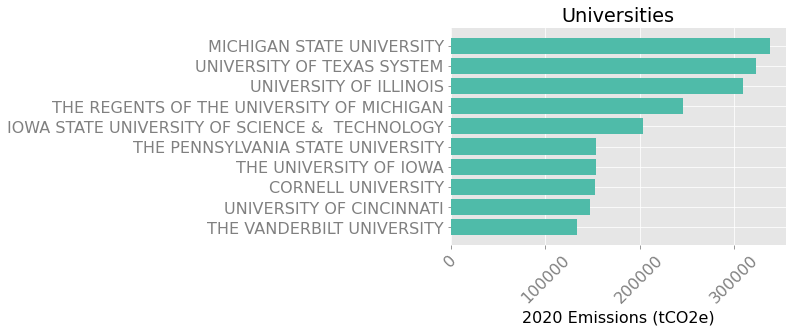

In [22]:
from ECHO_modules import utilities
def bar_chart(data, title):
  fig, ax = utilities.plt.subplots()
  ax.barh(utilities.np.arange(data.shape[0]), data["PARENT EMISSIONS AMT"])
  ax.set_yticks(utilities.np.arange(data.shape[0]))
  ax.set_yticklabels(list(data.index))
  ax.invert_yaxis() 
  ax.set_xlabel(year+' Emissions (tCO2e)')
  ax.set_title(title)
  ax.ticklabel_format(axis = 'x', style='plain')
  utilities.plt.xticks(rotation=45)
  utilities.plt.show()
bar_chart(e, 'Universities')

In addition to some universities, cities too are publicly-controlled entities that may be key targets for GHG emissions reduction or divestment. How much do they emit? Which cities?

In [23]:
e = summary_e.query("index.str.lower().str.contains('city of')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')
s = summary_s.query("index.str.lower().str.contains('city of')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(e.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(s.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
CITY OF LOS ANGELES,"2,826,566"
CITY OF LAKELAND,"1,281,472"
CITY OF TALLAHASSEE,"1,074,483"
CITY OF GAINESVILLE,"949,077"
CITY OF SPRINGFIELD,"887,880"
CITY WATER & LIGHT PLANT OF THE CITY OF JONESBORO,"565,033"
CITY OF EL PASO,"527,638"
PUBLIC UTILITIES BOARD OF THE CITY OF BROWNSVILLE TEXAS,"509,663"
CITY OF FARMINGTON,"462,490"


,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
CITY OF MEMPHIS,"4,299,744"
CITY OF RICHMOND,"1,170,827"
CITY OF KINGS MOUNTAIN,"1,104,326"
CITY OF GAINESVILLE,"975,082"
CITY OF CARROLLTON,"566,298"
CITY OF LONG BEACH,"506,599"
BREWTON CITY OF (INC),"395,496"
CITY OF MADISON ALABAMA,"375,916"
CITY OF MUSCLE SHOALS,"375,916"


Here we'll create charts of this data.

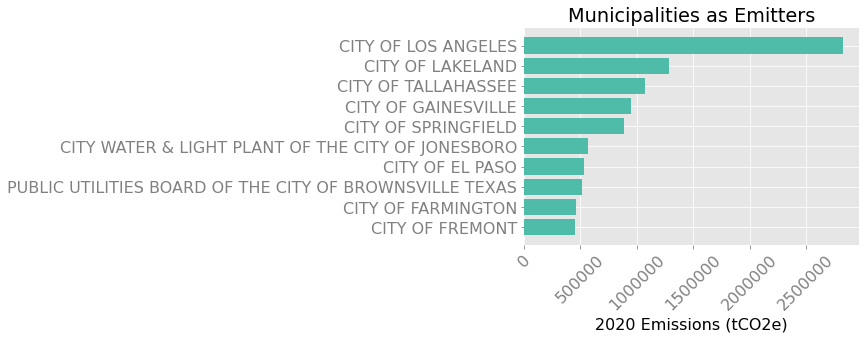

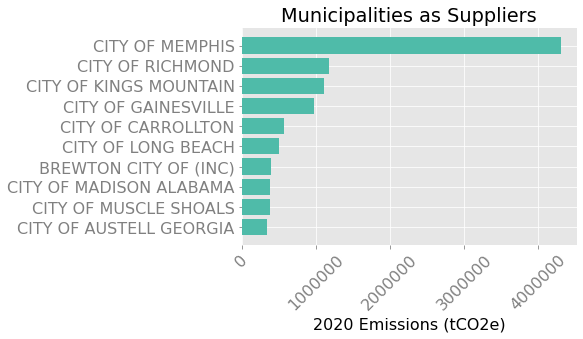

In [24]:
bar_chart(e, 'Municipalities as Emitters')
bar_chart(s, 'Municipalities as Suppliers')

You might be interested in exploring other kinds of entities (e.g. "Department of Defense")) or specific owners (e.g. "Koch Brothers", "Exxon", etc.) or entities associated with specific areas (e.g. "Chicago")

Run the following cell to produce a textbox where you can enter the specific term you want to search for.

In [25]:
search = widgets.Text(
  value='',
  placeholder='Type something here e.g. Exxon',
  description='Search:',
  disabled=False
)
display(search)

Text(value='', description='Search:', placeholder='Type something here e.g. Exxon')

Then run this cell to see the results!

In [26]:
e = summary_e.query("index.str.lower().str.contains('"+search.value.lower()+"')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

s = summary_s.query("index.str.lower().str.contains('"+search.value.lower()+"')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT')

display(HTML("<h2>"+year+"'s Direct Emitters:</h2>"))
display(e.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))
display(HTML("<h2>"+year+"'s Suppliers:</h2>"))
display(s.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'}))

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
VISTRA CORP,"91,785,525"
THE SOUTHERN CO,"75,654,997"
DUKE ENERGY CORP,"75,481,028"
BERKSHIRE HATHAWAY INC,"56,781,634"
AMERICAN ELECTRIC POWER CO INC,"54,017,451"
VOLT PARENT LP,"44,653,216"
NEXTERA ENERGY INC,"42,545,901"
EXXON MOBIL CORP,"40,995,403"
DOMINION ENERGY INC,"35,884,654"


,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
MARATHON PETROLEUM CORP,"401,574,105"
PHILLIPS 66,"324,103,187"
VALERO ENERGY CORP,"298,505,939"
EXXON MOBIL CORP,"282,093,557"
ENTERPRISE PRODUCTS PARTNERS LP,"168,952,523"
SHELL PETROLEUM INC,"149,092,739"
BP AMERICA INC,"133,602,244"
CHEVRON CORP,"132,910,747"
ARAMCO SERVICES CO,"102,916,368"
